In [1]:
import glob
import numpy as np
import os
import sys
sys.path.append('/home/jleland/Coding/Projects/flopter')
import magopter as mg
import constants as c
import lputils as lp
import matplotlib.pyplot as plt
import normalisation as nrm

2018-05-03_11h_31m_41s_TT_06551284859908422561.adc
[0, 2, 5, 6, 7]
49.8213006153 0.0497848963201 -46.5551175143 0.0084000028

FIT PARAMETERS
P = 0.025043186240698328 +/- 0.0
A = 0.07992873467774676 +/- 0.09332538860460395
y_0 = -46.30800794608534 +/- 0.053881438259399526
x_0 = 0.0014230246097799936 +/- 0.16852940935885052

1.00840033613 29.99991 0.025


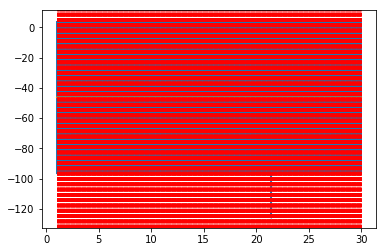

In [2]:
folders = ['2018-05-01_Leland/', '2018-05-02_Leland/', '2018-05-03_Leland/']
files = []
for folder in folders:
    os.chdir(mg.Magopter.get_data_path() + folder)
    files.extend(glob.glob('*.adc'))

files.sort()
# file = '2018-05-01_12h_55m_47s_TT_06550564404491814477.adc'  # 8
# file = '2018-05-03_11h_31m_41s_TT_06551284859908422561.adc'  # 82

files_of_interest = {
    8: "First analysed",
    82: "Higher Temp",
    97: "Angular Sweep with different probes"
}
file_index = 82
file = files[file_index]
print(file)

magopter = mg.Magopter(folder, file)

print(magopter.m_data.channels)
# length = len(magopter.t_file)
# for i in range(1, 20):
#     split = int(length / i)
# plt.figure()
# plt.title('i = {}'.format(i))
# plt.log
# for j in range(i):
#     plt.semilogy(magopter.t_file[j*split:j+1*split], label='j = {}'.format(j))

# plt.show()
dsr = 10
magopter.prepare(down_sampling_rate=dsr)
magopter.trim(trim_end=0.89)
# exit()
fit_df_0, fit_df_1 = magopter.fit()

In [3]:
df = fit_df_0.iloc[[200]]

In [4]:
fit_y = df.fit_y[:]
print(fit_y)
print(fit_y.shape)

6.020852    [0.407803943753, 0.407459554552, 0.40736329522...
Name: fit_y, dtype: object
(1,)


In [5]:
# Flush probe measurements
L_small = 3e-3  # m
a_small = 2e-3  # m
b_small = 3e-3  # m
g_small = 2e-3  # m
theta_f_small = np.radians(72)

L_large = 5e-3      # m
a_large = 4.5e-3    # m
b_large = 6e-3      # m
g_large = 1e-3      # m
theta_f_large = np.radians(73.3)

L_reg = 5e-3        # m
a_reg = 2e-3        # m
b_reg = 3.34e-3     # m
g_reg = 1e-3        # m
theta_f_reg = np.radians(75)

T_e = 1.78      # eV
n_e = 5.1e19    # m^-3
fwhm = 14.3     # mm
# T_e = 0.67      # eV
# n_e = 2.3e19    # m^-3
# fwhm = 16       # mm
deg_freedom = 3
gamma_i = (deg_freedom + 2) / 2
d_perp = 3e-4  # m
theta_p = np.radians(10)
theta_perp = np.radians(10)

A_coll_s = lp.calc_probe_collection_area(a_small, b_small, L_small, g_small, d_perp, theta_perp, theta_p,
                                         theta_f_small, print_fl=False)
A_coll_l = lp.calc_probe_collection_area(a_large, b_large, L_large, g_large, d_perp, theta_perp, theta_p,
                                         theta_f_large, print_fl=False)
A_coll_r = lp.calc_probe_collection_area(a_reg, b_reg, L_reg, g_reg, d_perp, theta_perp, theta_p, theta_f_reg,
                                         print_fl=False)

In [6]:
def gaussian_function(x, *parameters):
    amplitude = parameters[0]
    sigma = parameters[1] / 2.35482
    mu = parameters[2]
    return amplitude * np.exp(-0.5 * np.power((x - mu) / sigma, 2))

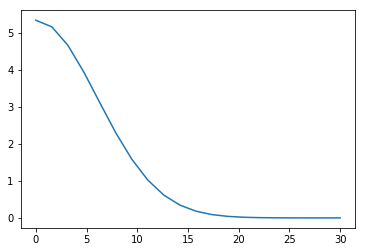

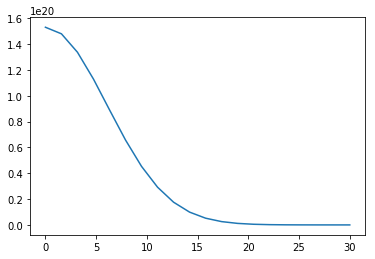

In [10]:
x = np.linspace(0, 30, 20)
y_t = gaussian_function(x, 3*T_e, fwhm, 0)
y_n = gaussian_function(x, 3*n_e, fwhm, 0)

plt.figure()
plt.plot(x, y_t)

plt.figure()
plt.plot(x, y_n)

(-0.2, 0.65)

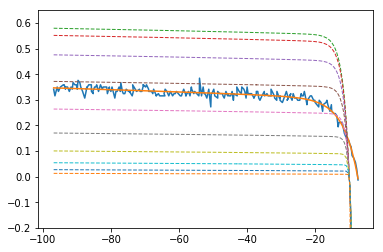

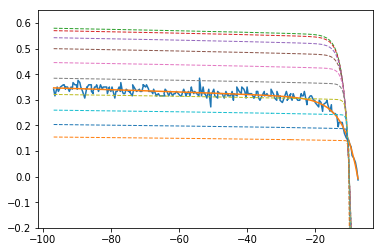

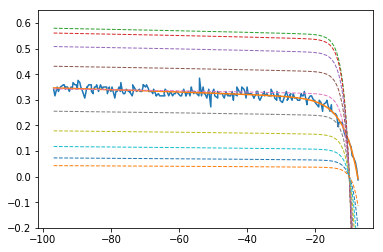

In [9]:
iv_data = fit_df_0.iloc[[100]]
plt.figure()
# for iv_curve in magopter.iv_arr_coax_0:
#     plt.plot(iv_curve.voltage, iv_curve.current)

plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.RAW_Y].tolist()[0], label='Raw IV')
plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.FIT_Y].tolist()[0], label='Fit IV')

iv_v_f = -10
currents = []
for i in range(len(y_t) - 10):
    temp = y_t[i]
    dens = y_n[i]
    I_s = lp.analytical_iv_curve(iv_data[c.RAW_X].tolist()[0], iv_v_f, temp, dens, theta_perp, A_coll_s, L=L_small, g=g_small)
    currents.append(I_s)
    plt.plot(iv_data[c.RAW_X].tolist()[0], I_s, label='{}mm'.format(x[i]), linestyle='dashed', linewidth=1)
# plt.legend(loc=10)
plt.ylim(-0.2, 0.65)

plt.figure()
plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.RAW_Y].tolist()[0], label='Raw IV')
plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.FIT_Y].tolist()[0], label='Fit IV')
for i in range(len(y_t) - 10):
    temp = y_t[i]
    I_s = lp.analytical_iv_curve(iv_data[c.RAW_X].tolist()[0], iv_v_f, temp, n_e, theta_perp, A_coll_s, L=L_small, g=g_small)
    currents.append(I_s)
    plt.plot(iv_data[c.RAW_X].tolist()[0], I_s, label='{}mm'.format(x[i]), linestyle='dashed', linewidth=1)
plt.ylim(-0.2, 0.65)

plt.figure()
plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.RAW_Y].tolist()[0], label='Raw IV')
plt.plot(iv_data[c.RAW_X].tolist()[0], iv_data[c.FIT_Y].tolist()[0], label='Fit IV')
for i in range(len(y_t) - 10):
    dens = y_n[i]
    I_s = lp.analytical_iv_curve(iv_data[c.RAW_X].tolist()[0], iv_v_f, T_e, dens, theta_perp, A_coll_s, L=L_small, g=g_small)
    currents.append(I_s)
    plt.plot(iv_data[c.RAW_X].tolist()[0], I_s, label='{}mm'.format(x[i]), linestyle='dashed', linewidth=1)
plt.ylim(-0.2, 0.65)

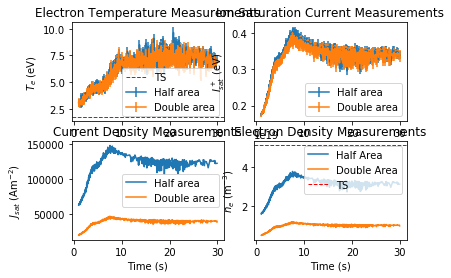

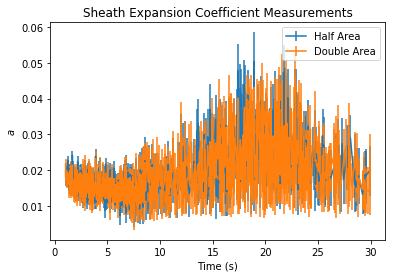

In [89]:
c_s = np.sqrt((nrm.ELEM_CHARGE * (T_e + gamma_i * T_e)) / nrm.PROTON_MASS)
n_e_0 = fit_df_0[c.ION_SAT] / (nrm.ELEM_CHARGE * c_s * A_coll_s)
n_e_1 = fit_df_1[c.ION_SAT] / (nrm.ELEM_CHARGE * c_s * A_coll_l)

J_sat_0 = fit_df_0[c.ION_SAT] / A_coll_s
J_sat_1 = fit_df_1[c.ION_SAT] / A_coll_l

plt.figure()
plt.subplot(221)
plt.title('Electron Temperature Measurements')
plt.xlabel('Time (s)')
plt.ylabel(r'$T_e$ (eV)')
plt.errorbar(fit_df_0.index, c.ELEC_TEMP, yerr=c.ERROR_STRING.format(c.ELEC_TEMP), data=fit_df_0, label='Half area')
plt.errorbar(fit_df_1.index, c.ELEC_TEMP, yerr=c.ERROR_STRING.format(c.ELEC_TEMP), data=fit_df_1,
             label='Double area')
plt.axhline(y=T_e, linestyle='dashed', linewidth=1, color='r', label='TS')
plt.legend()

plt.subplot(222)
plt.title('Ion Saturation Current Measurements')
plt.xlabel('Time (s)')
plt.ylabel(r'$I^+_{sat}$ (eV)')
plt.errorbar(fit_df_0.index, c.ION_SAT, yerr=c.ERROR_STRING.format(c.ION_SAT), data=fit_df_0, label='Half area')
plt.errorbar(fit_df_1.index, c.ION_SAT, yerr=c.ERROR_STRING.format(c.ION_SAT), data=fit_df_1, label='Double area')
for arc in magopter.arcs:
    plt.axvline(x=arc, linestyle='dashed', linewidth=1, color='r')
plt.legend()

# plt.figure()
plt.subplot(223)
plt.title('Current Density Measurements')
plt.xlabel('Time (s)')
plt.ylabel(r'$J_{sat}$ (Am$^{-2}$)')
plt.plot(fit_df_0.index, J_sat_0, label='Half area')
plt.plot(fit_df_1.index, J_sat_1, label='Double area')
for arc in magopter.arcs:
    plt.axvline(x=arc, linestyle='dashed', linewidth=1, color='r')
plt.legend()

# plt.figure()
plt.subplot(224)
plt.title('Electron Density Measurements')
plt.xlabel('Time (s)')
plt.ylabel(r'$n_e$ (m$^{-3}$)')
plt.plot(fit_df_0.index, n_e_0, label='Half Area')
plt.plot(fit_df_1.index, n_e_1, label='Double Area')
plt.axhline(y=n_e, linestyle='dashed', linewidth=1, color='r', label='TS')
plt.legend()

plt.figure()
plt.title('Sheath Expansion Coefficient Measurements')
plt.xlabel('Time (s)')
plt.ylabel(r'$a$')
plt.errorbar(fit_df_0.index, c.SHEATH_EXP, yerr=c.ERROR_STRING.format(c.SHEATH_EXP), data=fit_df_0,
             label='Half Area')
plt.errorbar(fit_df_1.index, c.SHEATH_EXP, yerr=c.ERROR_STRING.format(c.SHEATH_EXP), data=fit_df_1,
             label='Double Area')
plt.legend()